In [23]:
import pandas as pd
import numpy as np
import networkx as nx
import matplotlib as plt
from helpers import *


# Importing Data

### Metadata about the articles

In [24]:
# Articles is the name of all the articles in our dataset
# the index serves also as an id to retrieve articles in other files
# the names are url encoded
articles_df = pd.read_csv("./data/wikispeedia_paths-and-graph/articles.tsv",names = ["name"] ,skiprows=12,sep="\t")

#The categories of the articles, row index is the same as for the articles df
categories_df = pd.read_csv("./data/wikispeedia_paths-and-graph/categories.tsv",names = ["name","category"],skiprows=13, sep="\t")
categories_df = categories_df.groupby(["name"]).agg(lambda x : list(x))
categories_df = articles_df.join(categories_df,on="name",how="left")
categories_df.category = categories_df.category.apply(lambda d: d if isinstance(d, list) else [])

#each row of of the links df contains the list of article names that an article links to
links_df = pd.read_csv("./data/wikispeedia_paths-and-graph/links.tsv",skiprows=12, names = ["from","to"],sep="\t")
out_links_df = links_df.groupby(["from"]).agg(lambda x : list(x))
out_links_df = pd.merge(articles_df,out_links_df,left_on="name",right_on="from",how="left")
out_links_df.to = out_links_df.to.apply(lambda d: d if isinstance(d, list) else [])

in_links_df = links_df.groupby(["to"]).agg(lambda x : list(x))
in_links_df = pd.merge(articles_df,in_links_df,left_on="name",right_on="to",how="left")
in_links_df["from"] = in_links_df["from"].apply(lambda d: d if isinstance(d, list) else [])

#
shortest_path_distance = pd.read_csv("./data/wikispeedia_paths-and-graph/shortest-path-distance-matrix.txt",names=["distances"], skiprows=17)
#print(links_df)

"""
print("Articles")
display(articles_df)
print("Categories")
display(categories_df)
print("Links")
display(links_df)
print("shortest_path_distance")
display(shortest_path_distance)
"""

'\nprint("Articles")\ndisplay(articles_df)\nprint("Categories")\ndisplay(categories_df)\nprint("Links")\ndisplay(links_df)\nprint("shortest_path_distance")\ndisplay(shortest_path_distance)\n'

In [25]:
G = nx.from_pandas_edgelist(links_df,source="from", target="to", create_using=nx.DiGraph())

print((nx.shortest_path_length(G,source="Asteroid",target="Viking")))


3


### Creating a Dataframe/Graph of Topics (categories)

In [26]:
#We define a new Dataframe similar to Links but with Topics instead of Articles

topics_df = pd.merge(links_df,categories_df, left_on="from",right_on="name")
topics_df = topics_df.rename(columns={'category': 'category_from' })[['to','category_from']]

topics_df = pd.merge(topics_df, categories_df , left_on = "to",right_on="name")
topics_df = topics_df.rename(columns={'category': 'category_to' })[['category_from','category_to']]
topics_df.head()
topics = topics_df.explode('category_from').explode('category_to').dropna()
topics_general = topics.copy()
topics = topics.groupby(by=["category_from","category_to"]).size().reset_index()
topics = topics.rename(columns= {0 : 'count'}) #we can use the count to have a weighted graph
display(topics)

,category_from,category_to,count
0,subject.Art.Art,subject.Art.Art,122
1,subject.Art.Art,subject.Business_Studies.Business,6
2,subject.Art.Art,subject.Business_Studies.Companies,1
3,subject.Art.Art,subject.Business_Studies.Economics,1
4,subject.Art.Art,subject.Citizenship.Culture_and_Diversity,9
...,...,...,...
10181,subject.Science.Physics.The_Planets,subject.Science.Chemistry.Materials_science,1
10182,subject.Science.Physics.The_Planets,subject.Science.Physics.General_Physics,41
10183,subject.Science.Physics.The_Planets,subject.Science.Physics.Space_Astronomy,130
10184,subject.Science.Physics.The_Planets,subject.Science.Physics.Space_transport,24


In [27]:
topics_general = topics_general.drop_duplicates(subset=['category_from']).dropna()
topics_general["category_from"] = topics_general["category_from"]+  topics_general["category_to"]
topics_general = topics_general.drop_duplicates(subset=['category_from']).dropna()
print(topics_general.shape)

(129, 2)


In [28]:
def reduce(s):
    index1 = s.find('.')
    if index1==-1 :
        return s
    if '.' in s[index1+1:]:
        index2 = s.index('.',index1+1)
    else :
        return s[0:index1]
    return s[0:index2]

print(reduce("subject.Art.Art"))
print(reduce("IJEFNî~îÏÂÈ~ÂœîÏ"))

subject.Art
IJEFNî~îÏÂÈ~ÂœîÏ


In [29]:
topics_general["category_from"] = topics_general["category_from"].apply(lambda x: reduce(str(x) ))
topics_general["category_to"] = topics_general["category_to"].apply(lambda x: reduce(str(x) ))

In [30]:
topics_general = topics_general.groupby(by=["category_from","category_to"]).size().reset_index()
topics_general = topics_general.rename(columns= {0 : 'count'}) #we can use the count to have a weighted graph
topics_general.shape

(36, 3)

In [31]:
#Adding weight to the edges
topics2 = topics.groupby(by="category_from").sum()
topics = pd.merge(topics,topics2,left_on='category_from',right_on='category_from')
topics["weight"] = topics["count_x"]/topics["count_y"]
topics.head()

/var/folders/cd/j1lnjfnj3d978lfgybgtgysw0000gn/T/ipykernel_30477/1606199837.py:2: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  topics2 = topics.groupby(by="category_from").sum()


,category_from,category_to,count_x,count_y,weight
0,subject.Art.Art,subject.Art.Art,122,1198,0.101836
1,subject.Art.Art,subject.Business_Studies.Business,6,1198,0.005008
2,subject.Art.Art,subject.Business_Studies.Companies,1,1198,0.000835
3,subject.Art.Art,subject.Business_Studies.Economics,1,1198,0.000835
4,subject.Art.Art,subject.Citizenship.Culture_and_Diversity,9,1198,0.007513


2


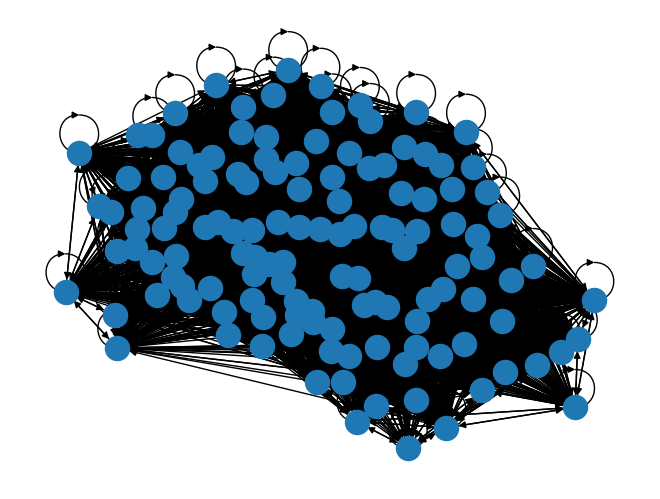

In [32]:
#Creating final Graph
G_topics = nx.from_pandas_edgelist(topics, source="category_from", target="category_to", edge_attr= "weight", create_using=nx.DiGraph() )
nx.draw(G_topics)
print((nx.shortest_path_length(G_topics,source="subject.Art.Art",target="subject.Science.Physics.Space_transport")))

In [33]:
G_topics.number_of_nodes()

129

In [34]:
#Creating DataFrame fo IN/OUT topics
in_topics_df = topics_df.explode("category_to").rename(columns={"category_to":"topic","category_from":"from"})
in_topics_df = in_topics_df[["topic","from"]]
in_topics_df = in_topics_df.groupby(by="topic").agg(sum)
#in_topics_df = in_topics_df.set_index("topic")
#display(in_topics_df)

out_topics_df = topics_df.explode("category_from").rename(columns={"category_from":"topic","category_to":"to"})
out_topics_df = out_topics_df.groupby(by="topic").agg(sum)
#out_topics_df = out_topics_df.set_index("topic")
#display(out_topics_df)


### Adding metric to the nodes of ARTICLES of using the graph

In [35]:
### Time Consuming ! #####

#dictionnary that has the avergae value of closeness centrality for each node of article
closeness = nx.closeness_centrality(G)
betweenness = nx.betweenness_centrality(G)
#pagerank = nx.pagerank(G)

In [36]:
nodes = pd.merge(in_links_df, out_links_df, on="name")
nodes = nodes.set_index(nodes['name'])
nodes["in_degrees"] = nodes["to"].apply(lambda x : len(x) )
nodes["out_degrees"] = nodes["from"].apply(lambda x : len(x) )
nodes["closeness_centrality"] = nodes.index.to_series().apply(lambda x :  closeness.get(x,-1) )
nodes["betweenness_centrality"] = nodes.index.to_series().apply(lambda x : betweenness.get(x,-1))
#nodes["pagerank_centrality"] = nodes.name.apply(lambda x : pagerank.get(x,-1))

nodes = nodes.drop(["name"],axis=1)
#nodes.head(20)
#display(nodes[(nodes.betweenness_centrality >0) & (nodes.closeness_centrality >0)])
#display(nodes[nodes.closeness_centrality==-1])

### Adding metric to the nodes of TOPICS of using the graph

In [37]:
#dictionnary that has the avergae value of closeness centrality for each node of article
closeness = nx.closeness_centrality(G_topics)
betweenness = nx.betweenness_centrality(G_topics)

In [38]:
nodes_t = pd.merge(in_topics_df, out_topics_df,on="topic")
nodes_t["in_degrees"] = nodes_t["to"].apply(lambda x : len(x) )
nodes_t["out_degrees"] = nodes_t["from"].apply(lambda x : len(x) )
nodes_t["closeness_centrality"] = nodes_t.index.to_series().apply(lambda x :  closeness.get(x,-1) )
nodes_t["betweenness_centrality"] = nodes_t.index.to_series().apply(lambda x : betweenness.get(x,-1))
#nodes_t.sort_values(by="in_degrees",ascending=False).head()
display(nodes_t)

,from,to,in_degrees,out_degrees,closeness_centrality,betweenness_centrality
topic,,,,,,
subject.Art.Art,"[subject.People.Artists, subject.History.Gener...","[subject.History.British_History, subject.Citi...",1198,842,0.825806,0.004979
subject.Business_Studies.Business,"[subject.Countries, subject.Geography.European...","[subject.History.British_History, subject.Citi...",737,1396,0.853333,0.003592
subject.Business_Studies.Companies,"[subject.History.General_history, subject.Hist...","[subject.History.British_History, subject.Citi...",668,236,0.670157,0.002040
subject.Business_Studies.Currency,"[subject.Countries, subject.Geography.European...","[subject.Countries, subject.Geography.European...",933,1082,0.757396,0.001963
subject.Business_Studies.Economics,"[subject.History.General_history, subject.Busi...","[subject.Geography.Geography_of_Great_Britain,...",1158,513,0.727273,0.002197
...,...,...,...,...,...,...
subject.Science.Physics.Electricity_and_Electronics,"[subject.History.General_history, subject.Scie...","[subject.Countries, subject.Geography.European...",375,799,0.670157,0.001308
subject.Science.Physics.General_Physics,"[subject.Countries, subject.Geography.European...","[subject.History.British_History, subject.Citi...",1446,2589,0.847682,0.004590
subject.Science.Physics.Space_Astronomy,"[subject.Business_Studies.Currency, subject.Sc...","[subject.Countries, subject.Geography.European...",2257,1623,0.780488,0.003410


### Played games dataset

In [39]:
paths_finished_df = pd.read_csv("./data/wikispeedia_paths-and-graph/paths_finished.tsv",names = ["hashedIpAddress","timestamp","durationInSec","path","rating"],skiprows=16, sep="\t")
paths_finished_df["path"] = paths_finished_df["path"].apply(lambda x: x.split(";"))
paths_finished_df["start"] = paths_finished_df["path"].apply(lambda x: x[0])
paths_finished_df["target"] = paths_finished_df["path"].apply(lambda x: x[-1])
#paths_finished_df["path"] = paths_finished_df["path"].apply(lambda x: x[1:-1])
paths_finished_df["final_path"] = paths_finished_df["path"].apply(remove_backs)
paths_unfinished_df = pd.read_csv("./data/wikispeedia_paths-and-graph/paths_unfinished.tsv",names=["hashedIpAddress",   "timestamp ",  "durationInSec",  "path",   "target",   "type"],skiprows=17, sep="\t")
paths_unfinished_df["path"] = paths_unfinished_df["path"].apply(lambda x: x.split(";"))
paths_unfinished_df["start"] = paths_unfinished_df["path"].apply(lambda x: x[0])
#paths_unfinished_df["path"] = paths_unfinished_df["path"].apply(lambda x: x[1:])
paths_unfinished_df["final_path"] = paths_unfinished_df["path"].apply(remove_backs)

#deleting rows where the user would probably just started a game and forgot about it (timeout and no visited pages)
paths_unfinished_df = paths_unfinished_df.drop(paths_unfinished_df[(paths_unfinished_df["durationInSec"]>1800) & (paths_unfinished_df["path"].apply(lambda x: len(x)==0))].index)

print("finished paths")
display(paths_finished_df)
print("unfinished paths")
display(paths_unfinished_df)

finished paths


,hashedIpAddress,timestamp,durationInSec,path,rating,start,target,final_path
0,6a3701d319fc3754,1297740409,166,"[Atlantic_slave_trade, Africa, Accra, Atlantic...",NaN,14th_century,African_slave_trade,"[15th_century, 16th_century, Pacific_Ocean, At..."
1,3824310e536af032,1344753412,88,"[Atlantic_slave_trade, Africa, Europe]",3.0,14th_century,African_slave_trade,"[Europe, Africa, Atlantic_slave_trade]"
2,415612e93584d30e,1349298640,138,"[Atlantic_slave_trade, Africa, Slavery, Britis...",NaN,14th_century,African_slave_trade,"[Niger, Nigeria, British_Empire, Slavery, Afri..."
3,64dd5cd342e3780c,1265613925,37,"[Ancient_Greece, Renaissance]",NaN,14th_century,Greece,"[Renaissance, Ancient_Greece]"
4,015245d773376aab,1366730828,175,"[President_of_the_United_States, Ronald_Reagan...",3.0,14th_century,John_F._Kennedy,"[Italy, Roman_Catholic_Church, HIV, Ronald_Rea..."
...,...,...,...,...,...,...,...,...
51313,15a13a1d66ef5456,1349231015,66,[Ancient_Egypt],NaN,Yagan,Civilization,[Ancient_Egypt]
51314,2ef7ac844cefda58,1300254138,165,"[Novel, A_Christmas_Carol, Charles_Dickens, 19...",3.0,Yagan,Fiction,"[Folklore, 19th_century, Charles_Dickens, A_Ch..."
51315,12863abb7887f890,1385095372,228,"[Tennis, United_States, France, England, Austr...",NaN,Yagan,U.S._Open_%28tennis%29,"[Australia, England, France, United_States, Te..."
51316,19f8284371753362,1298792567,56,"[United_States, Australia]",1.0,Yarralumla%2C_Australian_Capital_Territory,Abraham_Lincoln,"[Australia, United_States]"


unfinished paths


,hashedIpAddress,timestamp,durationInSec,path,target,type,start,final_path
2,2b015fb8181c48f2,1297090819,1818,"[Alexander_the_Great, Democracy]",First_Crusade,timeout,Malawi,"[Democracy, Alexander_the_Great]"
3,53a53bc244e08a6a,1297094761,49,[],Mount_St._Helens,restart,Paraguay,[]
4,53a53bc244e08a6a,1297099105,1808,[Bolivia],Mount_St._Helens,timeout,Paraguay,[Bolivia]
5,131600803df4895e,1297100557,2009,"[Yangtze_River, China, History_of_the_world]",Grand_Canal_of_China,timeout,Agriculture,"[History_of_the_world, China, Yangtze_River]"
6,486bb79910fe9dd2,1297101660,1932,"[Asia, Afghanistan, Ancient_Greece, Renaissanc...",Scouting,timeout,Mind,"[Christianity, Europe, Renaissance, Ancient_Gr..."
...,...,...,...,...,...,...,...,...
24870,109ed71f571d86e9,1389787605,180,"[Ghana, Sub-Saharan_Africa, <, Philippines, Ma...",Cholera,restart,Franz_Kafka,"[Tuberculosis, World_Health_Organization, Mala..."
24871,232f992e57d43e8d,1389787697,6,[],Hollandic,restart,Modern_history,[]
24872,2e09a7224600a7cd,1389798400,1900,"[<, Popular_culture, Culture, Linguistics]",The_Beatles,timeout,Computer_programming,"[Linguistics, Culture]"
24873,60af9e2138051b96,1389799481,1903,"[Battle_of_Midway, World_War_II, United_Kingdom]",Alan_Turing,timeout,Jamaica,"[United_Kingdom, World_War_II, Battle_of_Midway]"


In [40]:
out_num_links = out_links_df["to"].apply(lambda x: len(x))
display(out_num_links[out_num_links==(out_num_links.max())])

in_num_links = in_links_df["from"].apply(lambda x: len(x))
display(in_num_links[in_num_links==(in_num_links.max())])

4297    294
Name: to, dtype: int64

4297    1551
Name: from, dtype: int64

In [41]:
#list of articles that were visited without the start and finish
visited_nodes_without_sf=paths_finished_df["final_path"].explode().value_counts()
visited_nodes_without_sf

United_States             8567
Europe                    4185
United_Kingdom            3665
Earth                     3076
England                   2937
                          ... 
Battle_of_Jutland            1
Guangzhou                    1
Anglo-Saxon_literature       1
Chennai                      1
Arcadia_%28play%29           1
Name: final_path, Length: 3280, dtype: int64

In [42]:
visited_nodes_without_sf=paths_unfinished_df["final_path"].explode().value_counts()
visited_nodes_without_sf

United_States              3348
United_Kingdom             1307
Europe                     1154
England                    1068
Earth                       940
                           ... 
Gaur                          1
Indian_Railways               1
Bantu                         1
Shackleton_%28crater%29       1
Anschluss                     1
Name: final_path, Length: 3073, dtype: int64

In [43]:
#Top frequent games played, allowing us to make comparisons
top_10_games_finished_df=paths_finished_df[["start","target","final_path"]].groupby(["start","target"]).count().sort_values(by="final_path",axis=0,ascending=False)[:10]
top_10_games = top_10_games_finished_df.index
display(top_10_games_finished_df)
top_10_games_unfinished_df=paths_unfinished_df[["start","target","path"]].groupby(["start","target"]).count().sort_values(by="path",axis=0,ascending=False)[:10]
display(top_10_games_unfinished_df)

,,final_path
start,target,
Asteroid,Viking,1043
Brain,Telephone,1040
Theatre,Zebra,905
Pyramid,Bean,642
Batman,Wood,148
Bird,Great_white_shark,138
Batman,The_Holocaust,119
Bird,Adolf_Hitler,107
Beer,Sun,99


path
start    target         
Brain    Telephone   906
Pyramid  Bean        902
Theatre  Zebra       806
Asteroid Viking      679
Batman   Wood         69
         Banana       53
Beer     Sun          41
Cat      Microsoft    40
Aircraft Google       40
Dog      Telephone    36

In [44]:
#Top frequent games played, allowing us to make comparisons
games_df = paths_finished_df[["start","target","path"]].groupby(["start","target"]).count().sort_values(by="path",axis=0,ascending=False)[:10]
display(paths_finished_df[["start","target","path"]].groupby(["start","target"]).agg(list))
display(games_df)
games_df = paths_unfinished_df[["start","target","path"]].groupby(["start","target"]).count().sort_values(by="path",axis=0,ascending=False)[:10]
display(games_df)

path
start                          target                                                                 
%E2%82%AC2_commemorative_coins Irish_Sea                                                   [[Ireland]]
10th_century                   11th_century                                               [[], [], []]
                               Banknote                            [[Coin, Silver, Maya_civilization]]
                               Country                                                     [[Germany]]
                               Harlem_Globetrotters  [[Basketball, United_States, France], [Basketb...
...                                                                                                ...
Zulu                           Arctic_Circle         [[Arctic, Canada, English_language], [Arctic, ...
                               Doom                  [[Computer_and_video_games, Computer, 20th_cen...
                               Jesus                                                  [[Christianity]]
                               Language                                           [[English_language]]
                               Slovenia              [[Europe, Continent, South_Africa], [Mediterra...

[28718 rows x 1 columns]

,,path
start,target,
Asteroid,Viking,1043
Brain,Telephone,1040
Theatre,Zebra,905
Pyramid,Bean,642
Batman,Wood,148
Bird,Great_white_shark,138
Batman,The_Holocaust,119
Bird,Adolf_Hitler,107
Beer,Sun,99


path
start    target         
Brain    Telephone   906
Pyramid  Bean        902
Theatre  Zebra       806
Asteroid Viking      679
Batman   Wood         69
         Banana       53
Beer     Sun          41
Cat      Microsoft    40
Aircraft Google       40
Dog      Telephone    36

##### We can see that there are some instances of the game that were played multiple times, and these games are both finished and unfinished,this can allow us to explore the different paths taken by different players (or same player), and analyize the pattern between them, especially comparing it to the shortest path and also comapring the different strategies

In [45]:
games_filtered_df = paths_finished_df[["start","target","final_path"]]
#masks = [(games_filtered_df["start"] == top_10_games[i][0]) & (games_filtered_df["target"] == top_10_games[i][1]) for i in range(len(top_10_games))]
#mask = reduce(np.logical_or, masks)
#games_filtered_df = games_filtered_df[mask]
#games_filtered_df["path_num_out_edges"] = games_filtered_df["final_path"].apply(lambda l: [out_num_links[(articles_df["name"]==art)].iloc[0] for art in l])
#display(games_filtered_df)

ZeroDivisionError: division by zero

<Figure size 4000x3000 with 0 Axes>

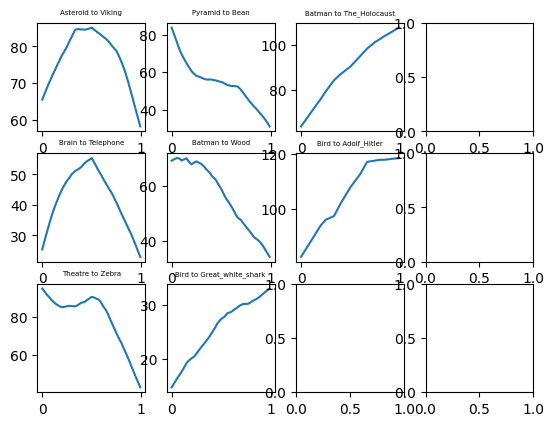

In [46]:
import math
from matplotlib.pyplot import figure
games_filtered_df = paths_finished_df[["start","target","final_path"]]
num_rows = math.floor(math.sqrt(len(top_10_games)))
num_cols = len(top_10_games)//num_rows + 1
figure(figsize=(8, 6), dpi=500)
figure, axis = plt.subplots(num_rows, num_cols)
  
for i,game in enumerate(top_10_games):
    games_filtered_df = paths_finished_df[["start","target","final_path"]]
    mask = (games_filtered_df["start"] == game[0]) & (games_filtered_df["target"] == game[1])
    games_filtered_df = games_filtered_df[mask]
    games_filtered_df["path_num_out_edges"] = games_filtered_df["final_path"].apply(lambda l: [out_num_links[(articles_df["name"]==art)].iloc[0] for art in l])
    
    xs,ys,stds = get_value_evolution(list(games_filtered_df["path_num_out_edges"]))
    ax = axis[i%num_rows, i//num_rows]
    ax.plot(xs, ys)
    ax.set_title(game[0] + " to "+ game[1],fontsize = 5)

    
